All libraries imported successfully
Data Loaded:
   Training: (888, 16), Test: (222, 16)
   Features: 16
Base models loaded: ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge', 'neural_network']
Ensemble Models Created:
   BAGGING NEURAL NETWORK
   BAGGING RANDOM FOREST
   BOOSTING GRADIENT BOOST
   STACKING NEURAL RIDGE NEURAL FINAL
   STACKING NEURAL RIDGE RIDGE FINAL
   STACKING NEURAL ONLY

NOTE: Bagging applied to Neural Network with 10 estimators
NOTE: Stacking with Neural Network final estimator
NOTE: Stacking with Ridge final estimator
NOTE: Neural-only stacking configuration

TRAINING ENSEMBLE MODELS WITH 10-FOLD CROSS-VALIDATION

[MODEL] Training BAGGING_NEURAL_NETWORK with 10-fold CV...

   [DURING TRAINING] Per-Fold Performance:
   Fold   Train RMSE     Val RMSE       Gap       
   --------------------------------------------
   1      2.1612         3.1562         0.9950    
   2      2.2599         2.4539         0.1940    
   3      2.2334         3.1649         0.

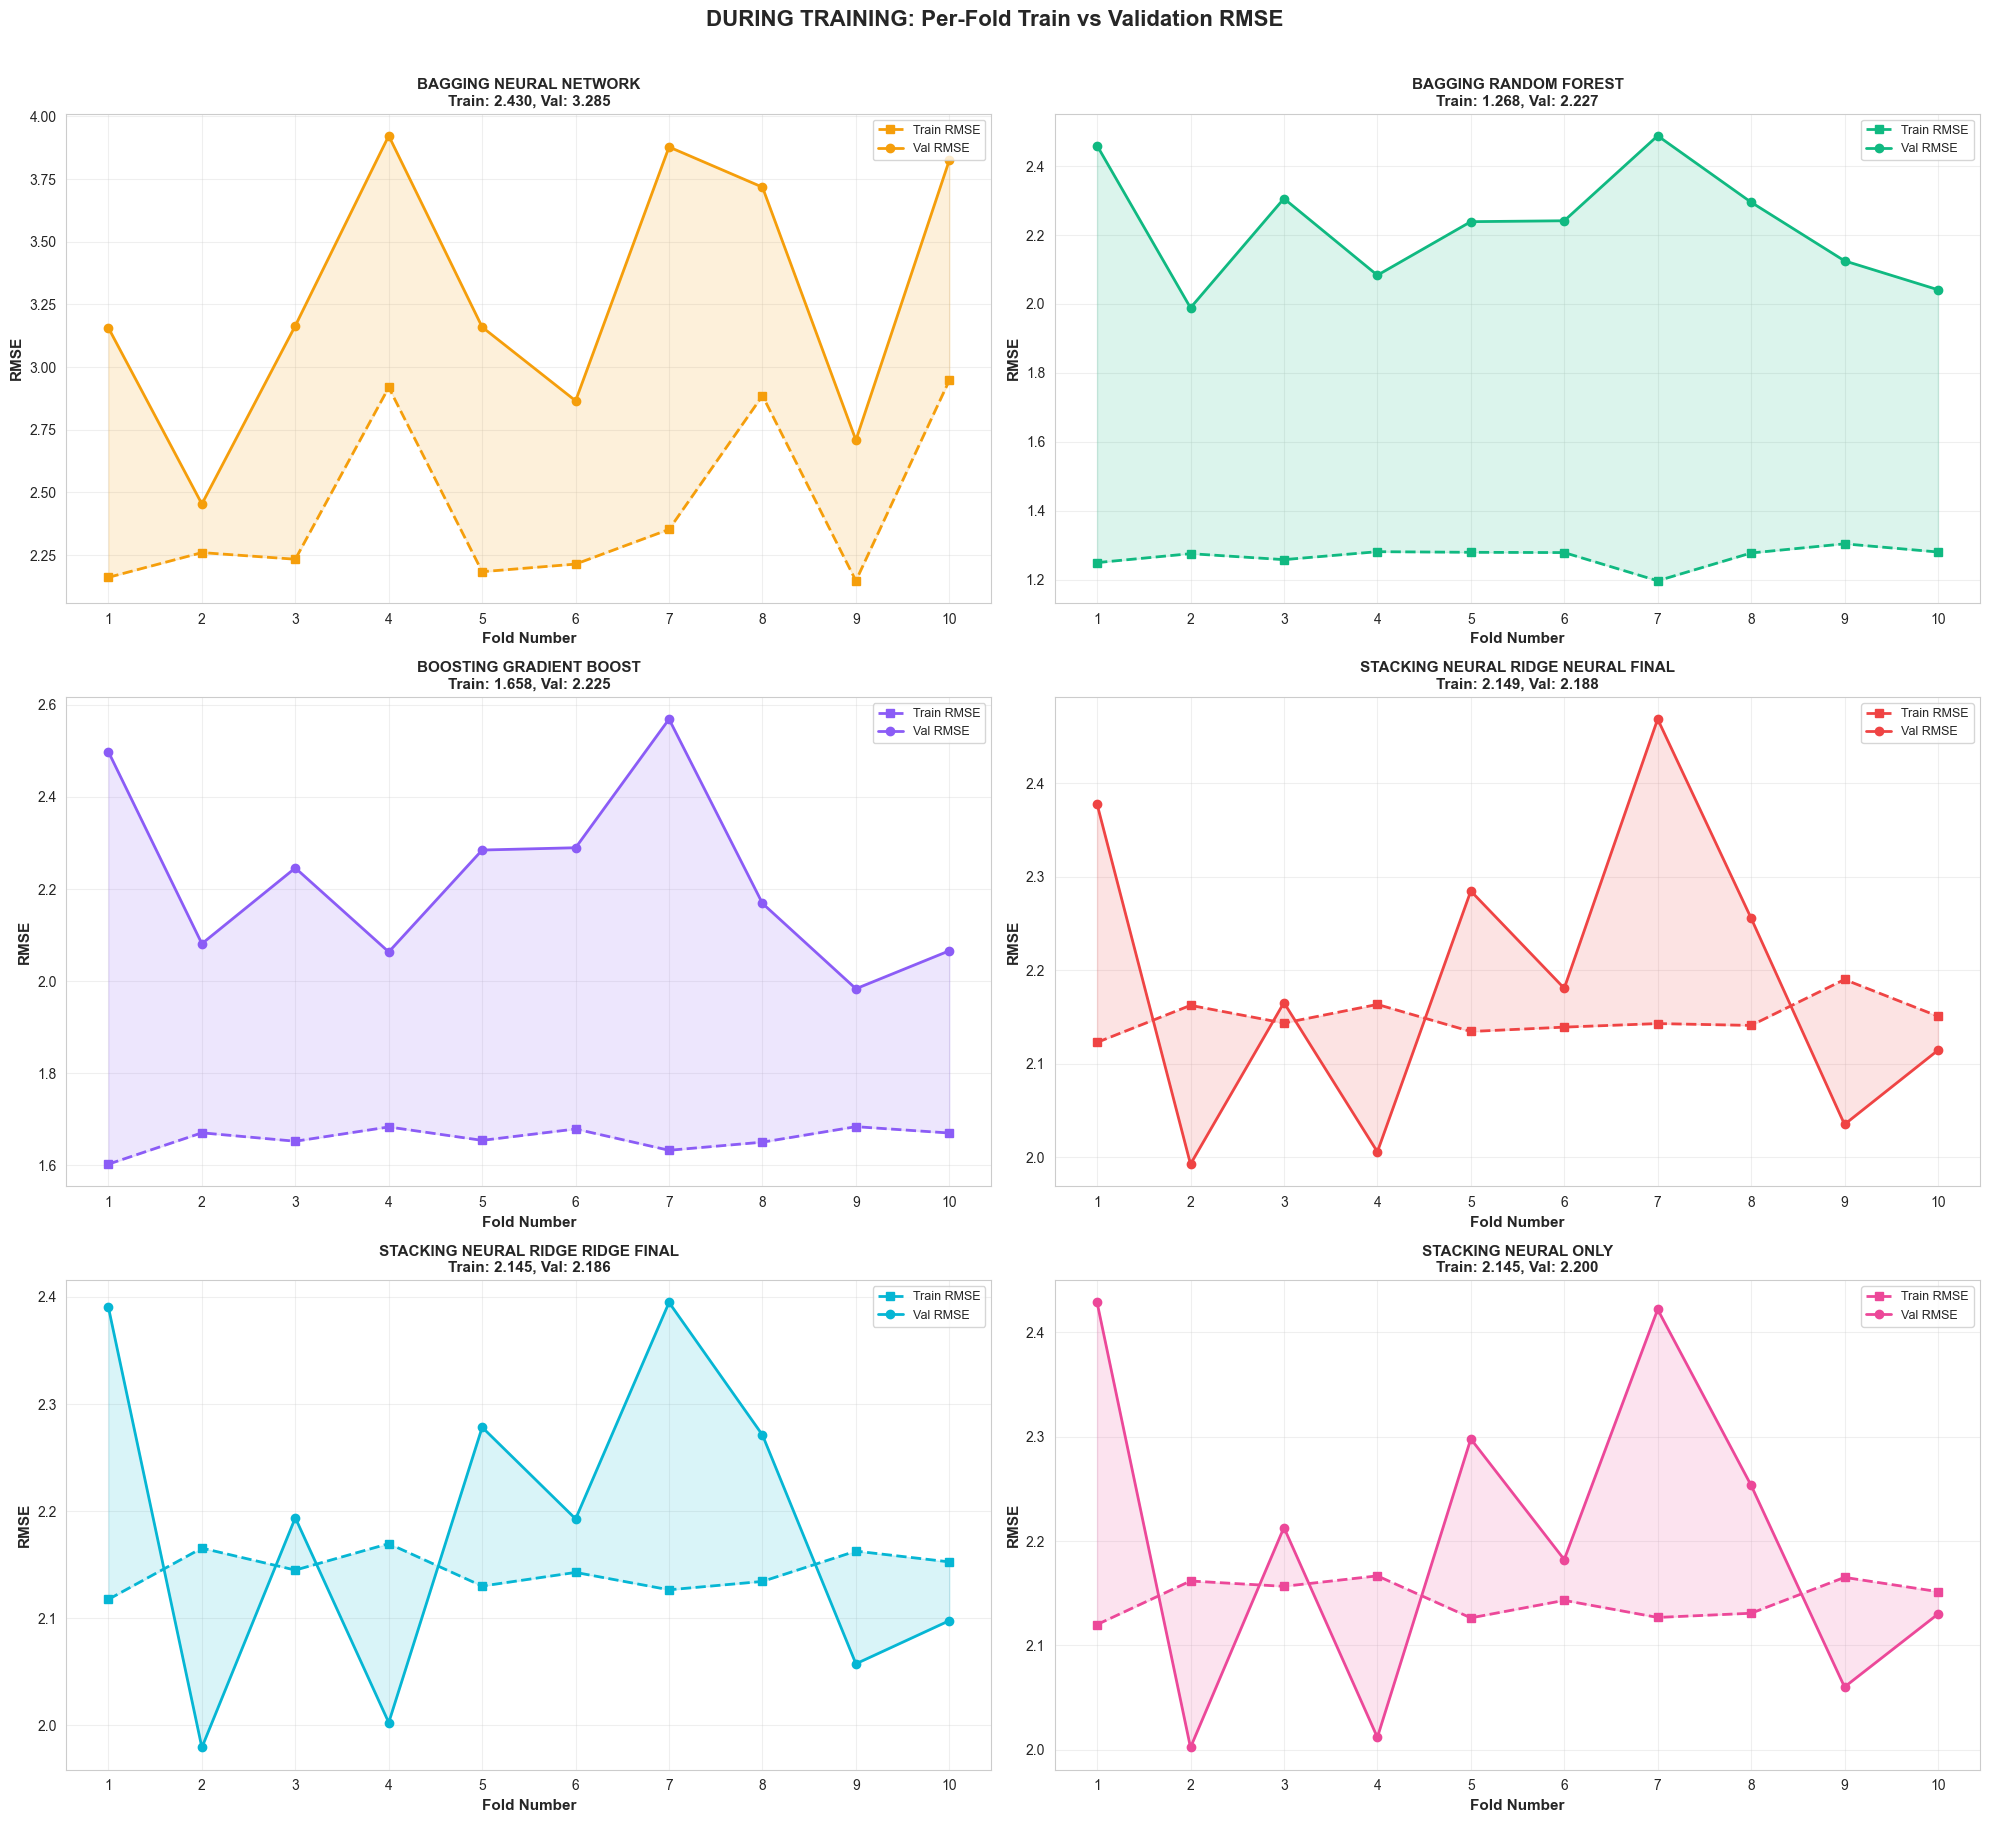


ENSEMBLE MODEL PERFORMANCE SUMMARY - DURING AND AFTER TRAINING
                             Model Train RMSE CV RMSE Test RMSE Train R2 Test R2 Test MAE Overfit Gap Time (s)
            BAGGING NEURAL NETWORK     2.0690  3.3228    3.1765   0.2329 -0.3461   2.5985      0.5790   258.29
             BAGGING RANDOM FOREST     1.2895  2.2325    2.5007   0.7021  0.1658   1.9949      0.5363     8.00
           BOOSTING GRADIENT BOOST     1.6871  2.2325    2.4745   0.4900  0.1831   1.9752      0.3068     3.22
STACKING NEURAL RIDGE NEURAL FINAL     2.1519  2.1935    2.4585   0.1702  0.1937   1.9927     -0.0235   158.09
 STACKING NEURAL RIDGE RIDGE FINAL     2.1491  2.1904    2.4513   0.1724  0.1984   1.9808     -0.0260   150.10
              STACKING NEURAL ONLY     2.1435  2.2050    2.4584   0.1766  0.1937   1.9948     -0.0171   156.57

DETAILED RESULTS RANKED BY TEST RMSE

Rank  Model                                              Train RMSE   CV RMSE      Test RMSE    R2         Overfit   
--

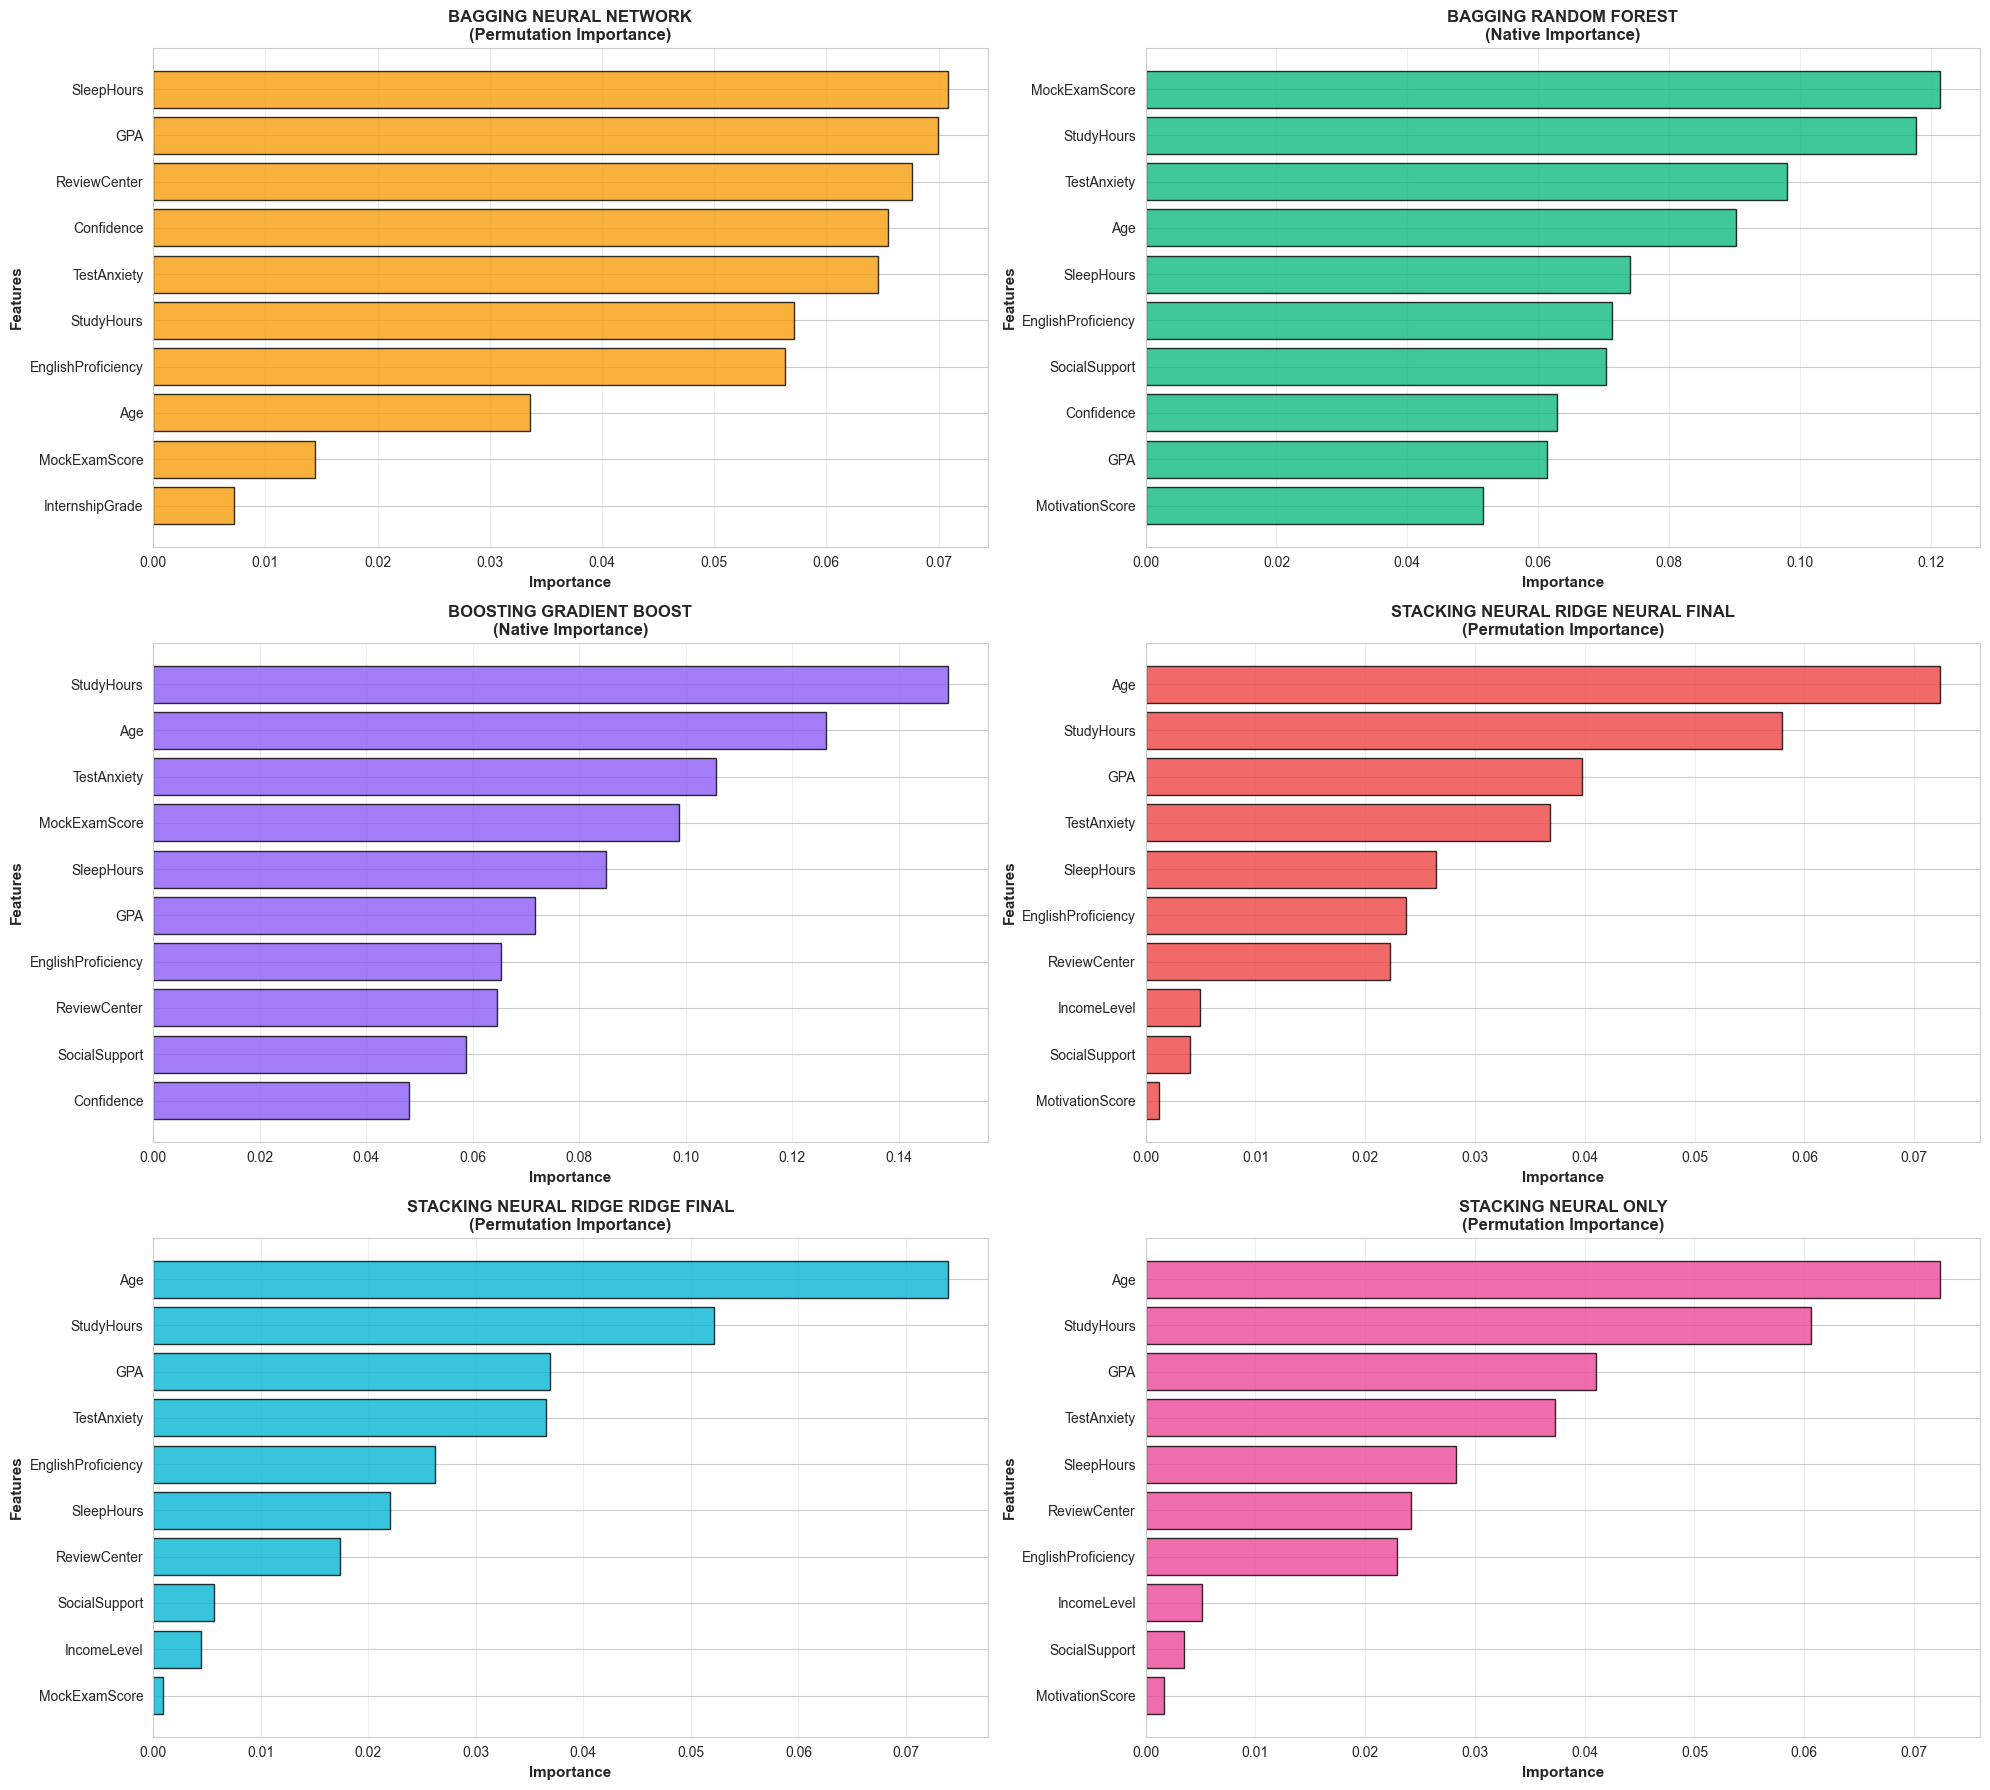

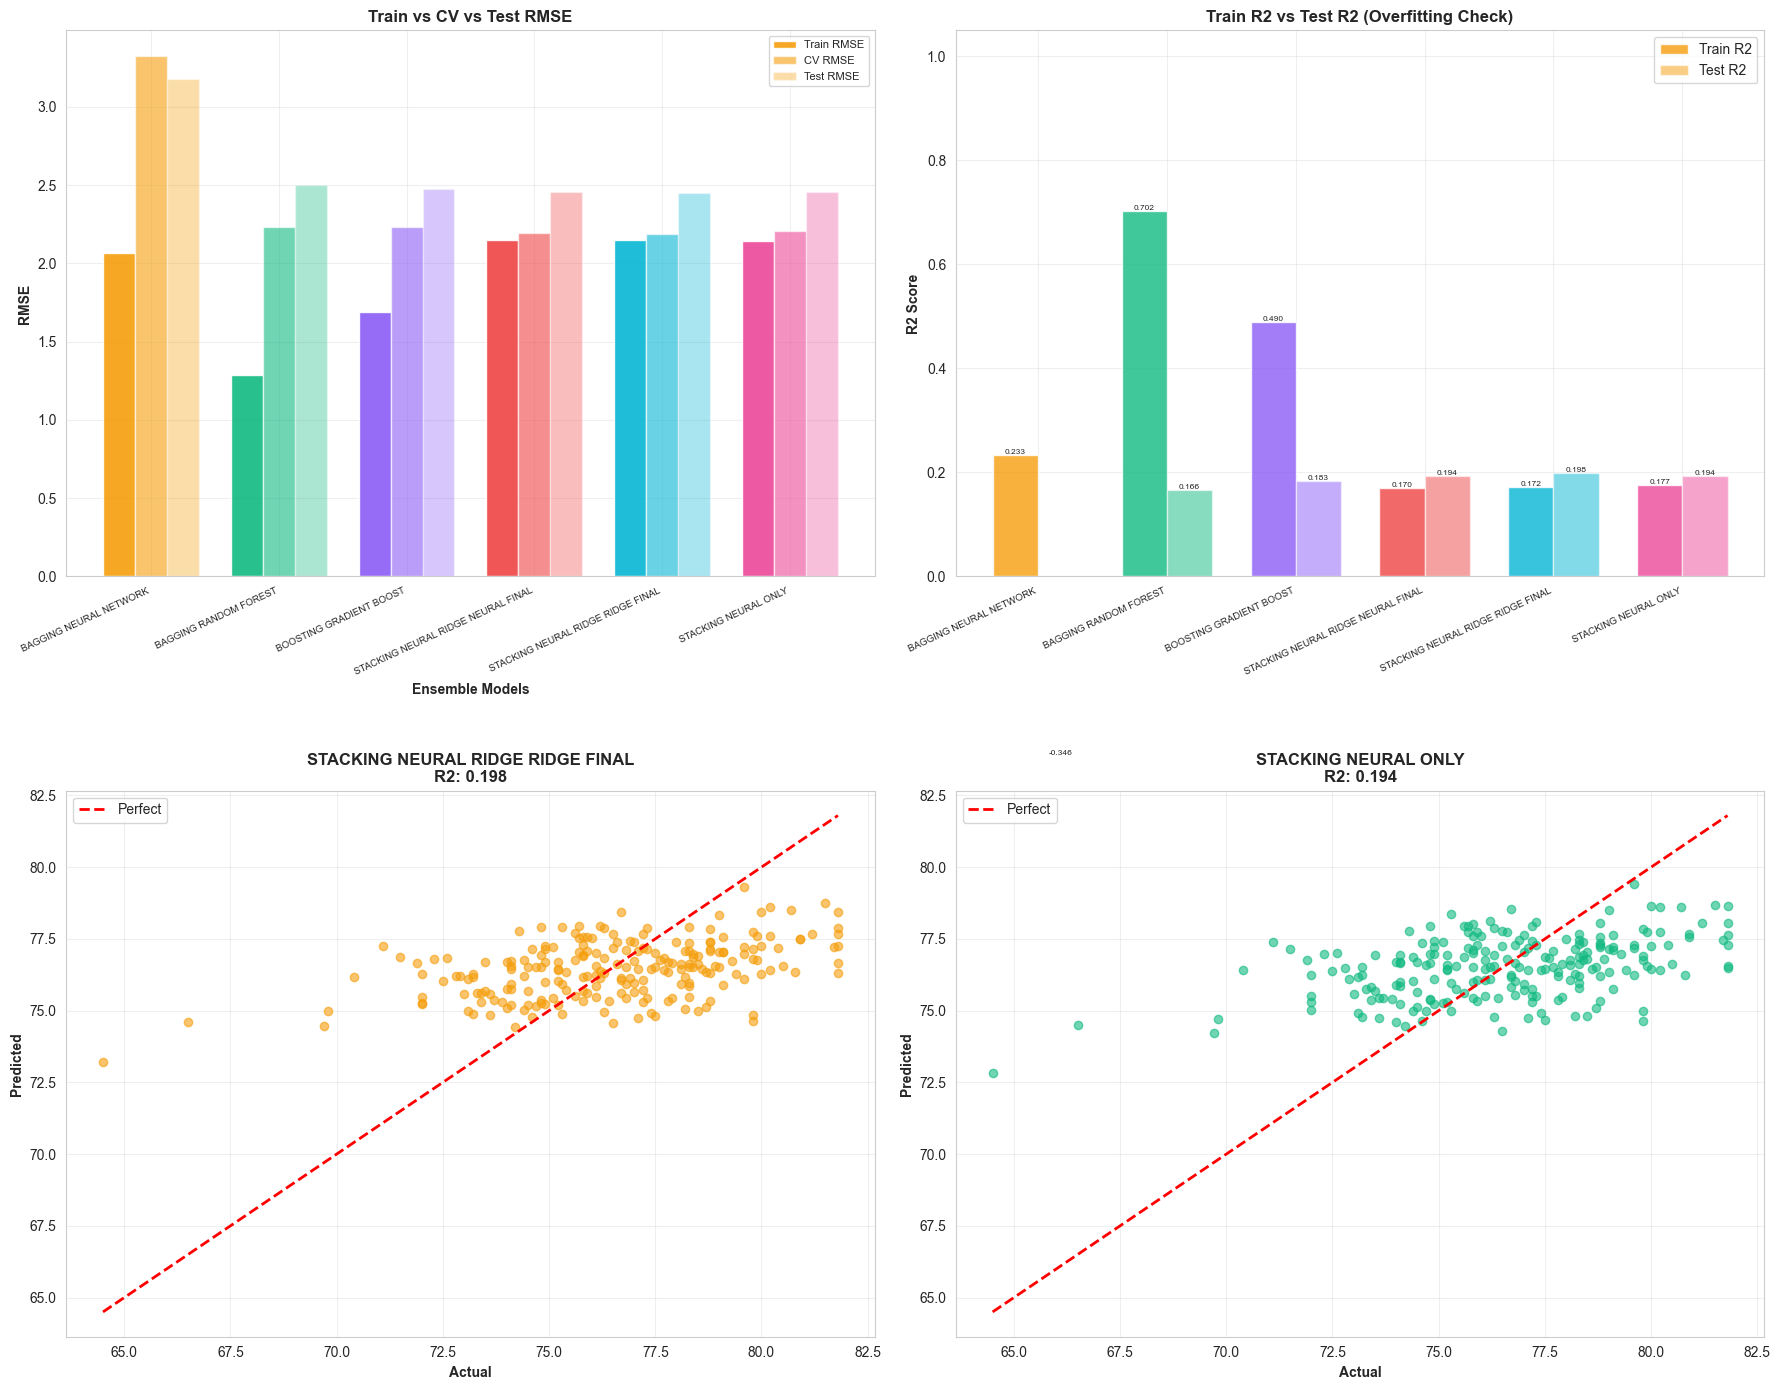


SAVING ENSEMBLE MODELS
   [OK] bagging_neural_network_ensemble.pkl saved and verified (Size: 1816821 bytes)
   [OK] bagging_random_forest_ensemble.pkl saved and verified (Size: 1950660 bytes)
   [OK] boosting_gradient_boost_ensemble.pkl saved and verified (Size: 133234 bytes)
   [OK] stacking_neural_ridge_neural_final_ensemble.pkl saved and verified (Size: 259091 bytes)
   [OK] stacking_neural_ridge_ridge_final_ensemble.pkl saved and verified (Size: 122258 bytes)
   [OK] stacking_neural_only_ensemble.pkl saved and verified (Size: 133954 bytes)

All ensemble models saved to: models/saved_ensemble_models/

ENSEMBLE vs BASE MODELS COMPARISON

    Type                              Model     RMSE      MAE
Ensemble  STACKING NEURAL RIDGE RIDGE FINAL 2.451288 1.980781
    Base                              RIDGE 2.456365 1.987608
Ensemble               STACKING NEURAL ONLY 2.458440 1.994808
Ensemble STACKING NEURAL RIDGE NEURAL FINAL 2.458513 1.992685
    Base                     NEURAL_NETWO

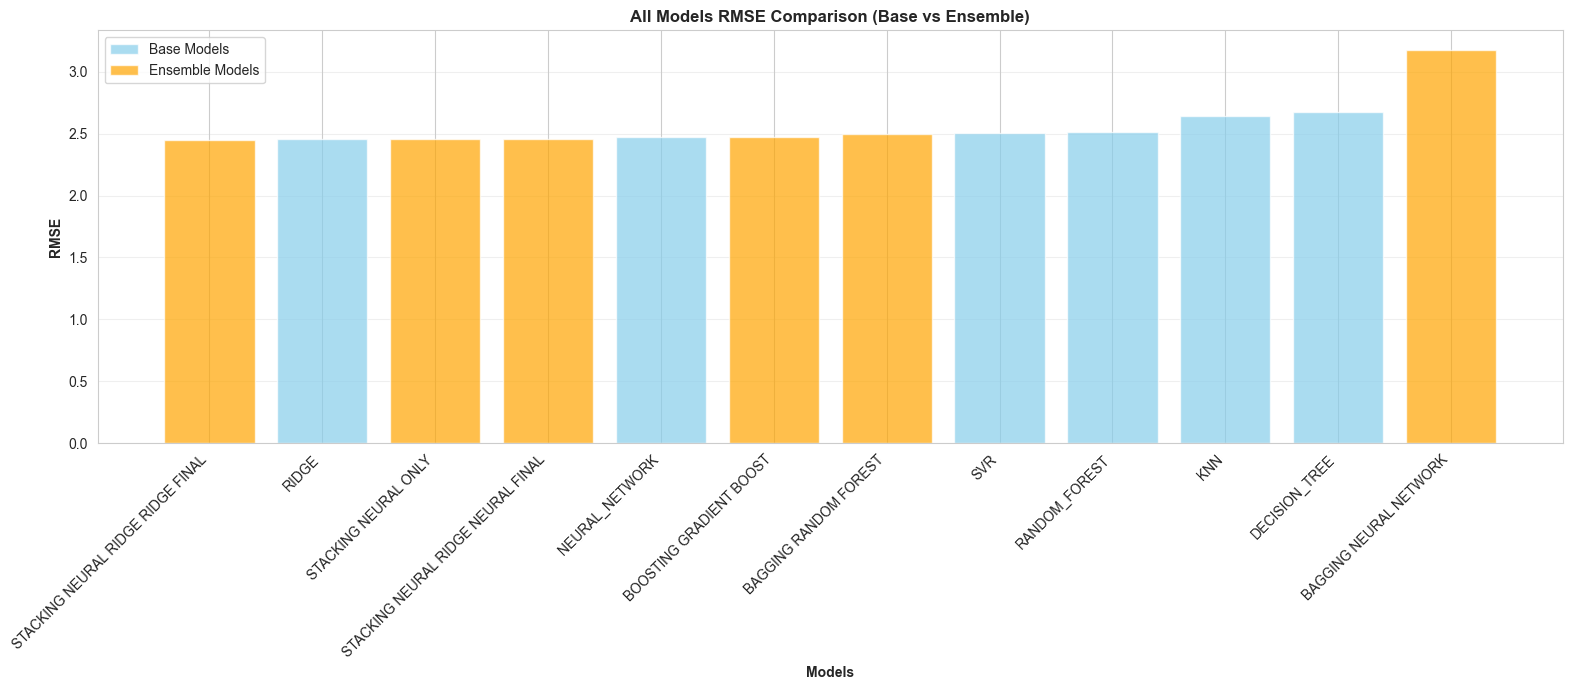


Best Overall Model: STACKING NEURAL RIDGE RIDGE FINAL
   Type: Ensemble
   RMSE: 2.4513
   MAE: 1.9808

STACKING FINAL ESTIMATOR COMPARISON

                             Model Final Estimator  Train RMSE  Test RMSE  CV RMSE  Train R2  Test R2  Overfit Gap
 STACKING NEURAL RIDGE RIDGE FINAL           Ridge    2.149082   2.451288 2.190410  0.172374 0.198385    -0.026010
              STACKING NEURAL ONLY  Neural Network    2.143525   2.458440 2.205021  0.176649 0.193700    -0.017051
STACKING NEURAL RIDGE NEURAL FINAL  Neural Network    2.151927   2.458513 2.193464  0.170182 0.193653    -0.023471

Analysis:
Ridge as final estimator generally provides more stable predictions
Neural Network as final estimator can capture complex patterns but may overfit
Choose Ridge for better generalization, Neural Network for complex data patterns

SAVING ENSEMBLE MODEL METADATA
   Saved metadata: ../regression_processed_data/bagging_neural_network_metadata.json
   Saved metadata: ../regression_processed

In [2]:
# Cell 1: Imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
from sklearn.base import clone
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("All libraries imported successfully")

# Cell 2: Load Data and Base Models
X_train = np.load('../regression_processed_data/X_train.npy')
X_test = np.load('../regression_processed_data/X_test.npy')
y_train = np.load('../regression_processed_data/y_train.npy')
y_test = np.load('../regression_processed_data/y_test.npy')

# Load feature names for feature importance analysis
with open('../regression_processed_data/feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Load base models
base_models = {}
for model_name in ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge', 'neural_network']:
    base_models[model_name] = joblib.load(f'../saved_base_models/{model_name}_model.pkl')

print(f"Data Loaded:")
print(f"   Training: {X_train.shape}, Test: {X_test.shape}")
print(f"   Features: {len(feature_names)}")
print(f"Base models loaded: {list(base_models.keys())}")

# Cell 3: Create Ensemble Models
# Neural network for bagging base estimator
neural_bagging_base = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    alpha=0.001,
    learning_rate='adaptive',
    random_state=42,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1
)

# Neural network for final estimator in stacking
neural_final_estimator = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    alpha=0.001,
    learning_rate='adaptive',
    random_state=42,
    max_iter=1000,
    early_stopping=True
)

# Ridge regression for final estimator in stacking
ridge_final_estimator = Ridge(
    alpha=1.0,
    random_state=42
)

ensemble_models = {
    'bagging_neural_network': BaggingRegressor(
        estimator=neural_bagging_base,
        n_estimators=10,
        max_samples=0.8,
        max_features=0.8,
        random_state=42,
        n_jobs=-1
    ),
    'bagging_random_forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        bootstrap=True
    ),
    'boosting_gradient_boost': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    'stacking_neural_ridge_neural_final': StackingRegressor(
        estimators=[
            ('neural_network', base_models['neural_network']),
            ('ridge', base_models['ridge'])
        ],
        final_estimator=neural_final_estimator,
        cv=5,
        n_jobs=-1
    ),
    'stacking_neural_ridge_ridge_final': StackingRegressor(
        estimators=[
            ('neural_network', base_models['neural_network']),
            ('ridge', base_models['ridge'])
        ],
        final_estimator=ridge_final_estimator,
        cv=5,
        n_jobs=-1
    ),
    'stacking_neural_only': StackingRegressor(
        estimators=[
            ('neural_network_1', base_models['neural_network'])
        ],
        final_estimator=MLPRegressor(
            hidden_layer_sizes=(50,),
            activation='relu',
            alpha=0.001,
            learning_rate='adaptive',
            random_state=42,
            max_iter=1000,
            early_stopping=True
        ),
        cv=5,
        n_jobs=-1
    )
}

print("Ensemble Models Created:")
for name in ensemble_models.keys():
    print(f"   {name.replace('_', ' ').upper()}")

print("\nNOTE: Bagging applied to Neural Network with 10 estimators")
print("NOTE: Stacking with Neural Network final estimator")
print("NOTE: Stacking with Ridge final estimator")
print("NOTE: Neural-only stacking configuration")

# Cell 4: Train Ensemble Models with 10-Fold CV - Track During and After Training
cv = KFold(n_splits=10, shuffle=True, random_state=42)
ensemble_results = {}

print("\n" + "=" * 70)
print("TRAINING ENSEMBLE MODELS WITH 10-FOLD CROSS-VALIDATION")
print("=" * 70)

for name, model in ensemble_models.items():
    print(f"\n{'='*60}")
    print(f"[MODEL] Training {name.upper()} with 10-fold CV...")
    print(f"{'='*60}")

    start_time = time.time()

    # -- DURING TRAINING: Per-fold train and validation scores --
    fold_train_mse_list = []
    fold_val_mse_list = []

    for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        fold_model = clone(model)
        fold_model.fit(X_fold_train, y_fold_train)

        # Training set score for this fold
        y_fold_train_pred = fold_model.predict(X_fold_train)
        fold_train_mse = mean_squared_error(y_fold_train, y_fold_train_pred)
        fold_train_mse_list.append(fold_train_mse)

        # Validation set score for this fold
        y_fold_val_pred = fold_model.predict(X_fold_val)
        fold_val_mse = mean_squared_error(y_fold_val, y_fold_val_pred)
        fold_val_mse_list.append(fold_val_mse)

    fold_train_rmse = [np.sqrt(mse) for mse in fold_train_mse_list]
    fold_val_rmse = [np.sqrt(mse) for mse in fold_val_mse_list]

    cv_train_rmse_mean = np.mean(fold_train_rmse)
    cv_train_rmse_std = np.std(fold_train_rmse)
    cv_val_rmse_mean = np.mean(fold_val_rmse)
    cv_val_rmse_std = np.std(fold_val_rmse)

    print(f"\n   [DURING TRAINING] Per-Fold Performance:")
    print(f"   {'Fold':<6} {'Train RMSE':<14} {'Val RMSE':<14} {'Gap':<10}")
    print(f"   {'-'*44}")
    for i in range(10):
        gap = fold_val_rmse[i] - fold_train_rmse[i]
        print(f"   {i+1:<6} {fold_train_rmse[i]:<14.4f} {fold_val_rmse[i]:<14.4f} {gap:<10.4f}")

    print(f"\n   During Training Summary:")
    print(f"      Avg Train RMSE: {cv_train_rmse_mean:.4f} +/- {cv_train_rmse_std:.4f}")
    print(f"      Avg Val RMSE:   {cv_val_rmse_mean:.4f} +/- {cv_val_rmse_std:.4f}")
    print(f"      Avg Fold Gap:   {cv_val_rmse_mean - cv_train_rmse_mean:.4f}")

    cv_mean = np.mean(fold_val_mse_list)
    cv_std = np.std(fold_val_mse_list)
    cv_rmse = np.sqrt(cv_mean)

    # -- AFTER TRAINING: Train on full training set --
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Training set evaluation
    y_pred_train = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_r2 = r2_score(y_train, y_pred_train)

    # Test set evaluation
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    overfit_gap = train_r2 - test_r2

    print(f"\n   [AFTER TRAINING] Final Model Performance:")
    print(f"      Training Set:")
    print(f"         RMSE: {train_rmse:.4f}")
    print(f"         MAE:  {train_mae:.4f}")
    print(f"         R2:   {train_r2:.4f}")
    print(f"      Test Set:")
    print(f"         RMSE: {test_rmse:.4f}")
    print(f"         MAE:  {test_mae:.4f}")
    print(f"         R2:   {test_r2:.4f}")
    print(f"      Overfit Gap (Train R2 - Test R2): {overfit_gap:.4f}")
    if overfit_gap > 0.1:
        print(f"      WARNING: Potential overfitting detected (gap > 0.1)")
    print(f"      Training Time: {training_time:.2f}s")

    ensemble_results[name] = {
        'model': model,
        # During training metrics
        'fold_train_mse': fold_train_mse_list,
        'fold_val_mse': fold_val_mse_list,
        'fold_train_rmse': fold_train_rmse,
        'fold_val_rmse': fold_val_rmse,
        'cv_train_rmse_mean': cv_train_rmse_mean,
        'cv_train_rmse_std': cv_train_rmse_std,
        'cv_val_rmse_mean': cv_val_rmse_mean,
        'cv_val_rmse_std': cv_val_rmse_std,
        # CV summary
        'cv_mse_mean': cv_mean,
        'cv_mse_std': cv_std,
        'cv_rmse': cv_rmse,
        'cv_10fold_scores': fold_val_mse_list,
        # After training - training set
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'train_mae': train_mae,
        'train_r2': train_r2,
        # After training - test set
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_pred': y_pred,
        'y_pred_train': y_pred_train,
        'training_time': training_time,
        'overfit_gap': overfit_gap
    }

# Cell 5: Visualize During Training - Per-Fold Train vs Val
model_names = list(ensemble_results.keys())
colors = ['#f59e0b', '#10b981', '#8b5cf6', '#ef4444', '#06b6d4', '#ec4899']

num_models = len(model_names)
rows = (num_models + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
axes_flat = axes.flatten()

for idx, name in enumerate(model_names):
    ax = axes_flat[idx]
    folds = range(1, 11)
    train_rmse_vals = ensemble_results[name]['fold_train_rmse']
    val_rmse_vals = ensemble_results[name]['fold_val_rmse']

    ax.plot(folds, train_rmse_vals, marker='s', linewidth=2, label='Train RMSE',
            color=colors[idx % len(colors)], linestyle='--')
    ax.plot(folds, val_rmse_vals, marker='o', linewidth=2, label='Val RMSE',
            color=colors[idx % len(colors)], linestyle='-')

    ax.fill_between(folds, train_rmse_vals, val_rmse_vals, alpha=0.15,
                    color=colors[idx % len(colors)])

    ax.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=11, fontweight='bold')
    ax.set_title(f'{name.replace("_", " ").upper()}\n'
                 f'Train: {ensemble_results[name]["cv_train_rmse_mean"]:.3f}, '
                 f'Val: {ensemble_results[name]["cv_val_rmse_mean"]:.3f}',
                 fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xticks(range(1, 11))

# Hide unused subplots
for idx in range(num_models, len(axes_flat)):
    axes_flat[idx].axis('off')

plt.suptitle('DURING TRAINING: Per-Fold Train vs Validation RMSE', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

# Cell 6: Compare Ensemble Models - Summary Table
summary_data = []
for name, data in ensemble_results.items():
    summary_data.append({
        'Model': name.replace('_', ' ').upper(),
        'Train RMSE': f"{data['train_rmse']:.4f}",
        'CV RMSE': f"{data['cv_rmse']:.4f}",
        'Test RMSE': f"{data['test_rmse']:.4f}",
        'Train R2': f"{data['train_r2']:.4f}",
        'Test R2': f"{data['test_r2']:.4f}",
        'Test MAE': f"{data['test_mae']:.4f}",
        'Overfit Gap': f"{data['overfit_gap']:.4f}",
        'Time (s)': f"{data['training_time']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 90)
print("ENSEMBLE MODEL PERFORMANCE SUMMARY - DURING AND AFTER TRAINING")
print("=" * 90)
print(summary_df.to_string(index=False))

print("\n" + "=" * 90)
print("DETAILED RESULTS RANKED BY TEST RMSE")
print("=" * 90)

sorted_models = sorted(ensemble_results.items(), key=lambda x: x[1]['test_rmse'])

print(f"\n{'Rank':<5} {'Model':<50} {'Train RMSE':<12} {'CV RMSE':<12} {'Test RMSE':<12} {'R2':<10} {'Overfit':<10}")
print("-" * 110)

for rank, (name, data) in enumerate(sorted_models, 1):
    print(f"{rank:<5} {name.replace('_', ' ').upper():<50} "
          f"{data['train_rmse']:<12.4f} {data['cv_rmse']:<12.4f} "
          f"{data['test_rmse']:<12.4f} {data['test_r2']:<10.4f} {data['overfit_gap']:<10.4f}")

best_model = sorted_models[0]
print(f"\nBest Ensemble Model: {best_model[0].replace('_', ' ').upper()}")
print(f"   Train RMSE: {best_model[1]['train_rmse']:.4f}")
print(f"   Test RMSE:  {best_model[1]['test_rmse']:.4f}")
print(f"   Test R2:    {best_model[1]['test_r2']:.4f}")
print(f"   Overfit Gap: {best_model[1]['overfit_gap']:.4f}")

# Cell 7: Detailed Ensemble Predictions Analysis
os.makedirs('../saved_ensemble_models', exist_ok=True)

print("\n" + "=" * 70)
print("ENSEMBLE TEST PREDICTIONS ANALYSIS")
print("=" * 70)

for name, data in ensemble_results.items():
    y_pred = data['y_pred']

    prediction_details = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'Absolute_Error': np.abs(y_test - y_pred),
        'Percent_Error': np.abs((y_test - y_pred) / y_test) * 100
    })

    print(f"\n{name.replace('_', ' ').upper()}")
    print(f"   [DURING TRAINING]")
    print(f"      Avg Train RMSE: {data['cv_train_rmse_mean']:.4f} +/- {data['cv_train_rmse_std']:.4f}")
    print(f"      Avg Val RMSE:   {data['cv_val_rmse_mean']:.4f} +/- {data['cv_val_rmse_std']:.4f}")
    print(f"   [AFTER TRAINING]")
    print(f"      Train RMSE: {data['train_rmse']:.4f}")
    print(f"      Train R2:   {data['train_r2']:.4f}")
    print(f"      Test RMSE:  {data['test_rmse']:.4f}")
    print(f"      Test MAE:   {data['test_mae']:.4f}")
    print(f"      Test R2:    {data['test_r2']:.4f}")

    residuals = y_test - y_pred
    print(f"      Mean Residual: {np.mean(residuals):.4f}")
    print(f"      Std Residual:  {np.std(residuals):.4f}")

    print(f"\n   Error Statistics:")
    print(f"   Mean Absolute Error: {prediction_details['Absolute_Error'].mean():.4f}")
    print(f"   Median Absolute Error: {prediction_details['Absolute_Error'].median():.4f}")
    print(f"   Max Error: {prediction_details['Absolute_Error'].max():.4f}")
    print(f"   Min Error: {prediction_details['Absolute_Error'].min():.4f}")

    print(f"\n   First 10 predictions:")
    print(prediction_details.head(10).to_string(index=False))

    large_errors = prediction_details[prediction_details['Absolute_Error'] > data['test_rmse']]
    if len(large_errors) > 0:
        print(f"\n   Samples with error > RMSE ({len(large_errors)} samples):")
        print(large_errors.head(5).to_string(index=False))

    csv_file = f'../saved_ensemble_models/{name}_test_predictions.csv'
    prediction_details.to_csv(csv_file, index=False)
    print(f"\n   Saved detailed predictions: {csv_file}")

# Cell 8: Feature Importance Analysis for Ensemble Models
print("\n" + "=" * 70)
print("ENSEMBLE FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

ensemble_feature_importance = {}

for name, data in ensemble_results.items():
    model = data['model']

    print(f"\n{name.replace('_', ' ').upper()}:")

    # Check if model has native feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_

        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)

        ensemble_feature_importance[name] = {
            'method': 'native',
            'importance': feature_importance_df.to_dict('records')
        }

        print(f"   Method: Native Feature Importance")
        print(f"   Top 10 Features:")
        print(feature_importance_df.head(10).to_string(index=False))

    else:
        # Use permutation importance
        print(f"   Calculating permutation importance...")

        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )

        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)

        ensemble_feature_importance[name] = {
            'method': 'permutation',
            'importance': feature_importance_df.to_dict('records')
        }

        print(f"   Method: Permutation Importance")
        print(f"   Top 10 Features:")
        print(feature_importance_df[['Feature', 'Importance', 'Std']].head(10).to_string(index=False))

# Save feature importance to JSON
print("\n" + "=" * 70)
print("SAVING FEATURE IMPORTANCE TO JSON")
print("=" * 70)

for name, importance_data in ensemble_feature_importance.items():
    json_file = f'../saved_ensemble_models/{name}_feature_importance.json'

    with open(json_file, 'w') as f:
        json.dump(importance_data, f, indent=2)

    print(f"   Saved: {name}_feature_importance.json")

print("\nAll feature importance files saved to: models/saved_ensemble_models/")

# Cell 9: Visualize Ensemble Feature Importance
num_fi_models = len(ensemble_feature_importance)
rows = (num_fi_models + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
axes_fi = axes.flatten()

colors_importance = ['#f59e0b', '#10b981', '#8b5cf6', '#ef4444', '#06b6d4', '#ec4899']

for idx, (name, importance_data) in enumerate(ensemble_feature_importance.items()):
    if idx >= len(axes_fi):
        break

    top_10 = importance_data['importance'][:10]
    features = [item['Feature'] for item in top_10]
    importances = [item['Importance'] for item in top_10]

    axes_fi[idx].barh(features, importances, color=colors_importance[idx % len(colors_importance)],
                   alpha=0.8, edgecolor='black')
    axes_fi[idx].set_xlabel('Importance', fontsize=11, fontweight='bold')
    axes_fi[idx].set_ylabel('Features', fontsize=11, fontweight='bold')
    axes_fi[idx].set_title(f'{name.replace("_", " ").upper()}\n({importance_data["method"].capitalize()} Importance)',
                       fontsize=12, fontweight='bold')
    axes_fi[idx].invert_yaxis()
    axes_fi[idx].grid(axis='x', alpha=0.3)

for idx in range(num_fi_models, len(axes_fi)):
    axes_fi[idx].axis('off')

plt.tight_layout()
plt.show()

# Cell 10: Visualize Ensemble After-Training Performance
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot 1: Train vs CV vs Test RMSE
x = np.arange(len(model_names))
width = 0.25

train_rmse_vals = [ensemble_results[name]['train_rmse'] for name in model_names]
cv_rmse_vals = [ensemble_results[name]['cv_rmse'] for name in model_names]
test_rmse_vals = [ensemble_results[name]['test_rmse'] for name in model_names]

axes[0, 0].bar(x - width, train_rmse_vals, width, label='Train RMSE',
               color=colors[:len(model_names)], alpha=0.9)
axes[0, 0].bar(x, cv_rmse_vals, width, label='CV RMSE',
               color=colors[:len(model_names)], alpha=0.6)
axes[0, 0].bar(x + width, test_rmse_vals, width, label='Test RMSE',
               color=colors[:len(model_names)], alpha=0.35)
axes[0, 0].set_xlabel('Ensemble Models', fontweight='bold')
axes[0, 0].set_ylabel('RMSE', fontweight='bold')
axes[0, 0].set_title('Train vs CV vs Test RMSE', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([n.replace('_', ' ').upper() for n in model_names],
                           rotation=25, ha='right', fontsize=7)
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(alpha=0.3)

# Plot 2: Train R2 vs Test R2
width = 0.35
train_r2_vals = [ensemble_results[name]['train_r2'] for name in model_names]
test_r2_vals = [ensemble_results[name]['test_r2'] for name in model_names]

bars1 = axes[0, 1].bar(x - width/2, train_r2_vals, width, label='Train R2',
               color=colors[:len(model_names)], alpha=0.8)
bars2 = axes[0, 1].bar(x + width/2, test_r2_vals, width, label='Test R2',
               color=colors[:len(model_names)], alpha=0.5)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=6)

axes[0, 1].set_ylabel('R2 Score', fontweight='bold')
axes[0, 1].set_title('Train R2 vs Test R2 (Overfitting Check)', fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels([n.replace('_', ' ').upper() for n in model_names],
                           rotation=25, ha='right', fontsize=7)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([0, 1.05])

# Plot 3 & 4: Prediction vs Actual for top 2 models
sorted_by_r2 = sorted(model_names, key=lambda x: ensemble_results[x]['test_r2'], reverse=True)
for idx, name in enumerate(sorted_by_r2[:2]):
    y_pred = ensemble_results[name]['y_pred']

    axes[1, idx].scatter(y_test, y_pred, alpha=0.6, color=colors[idx])

    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[1, idx].plot([min_val, max_val], [min_val, max_val],
                      'r--', linewidth=2, label='Perfect')

    axes[1, idx].set_xlabel('Actual', fontweight='bold')
    axes[1, idx].set_ylabel('Predicted', fontweight='bold')
    axes[1, idx].set_title(f'{name.replace("_", " ").upper()}\nR2: {ensemble_results[name]["test_r2"]:.3f}',
                          fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 11: Save Ensemble Models with Validation
import pickle

os.makedirs('../saved_ensemble_models', exist_ok=True)

print("\n" + "=" * 70)
print("SAVING ENSEMBLE MODELS")
print("=" * 70)

for name, data in ensemble_results.items():
    model_file = f'../saved_ensemble_models/{name}_ensemble.pkl'

    try:
        with open(model_file, 'wb') as f:
            pickle.dump(data['model'], f, protocol=pickle.HIGHEST_PROTOCOL)

        with open(model_file, 'rb') as f:
            loaded_model = pickle.load(f)

        file_size = os.path.getsize(model_file)
        print(f"   [OK] {name}_ensemble.pkl saved and verified (Size: {file_size} bytes)")

    except Exception as e:
        print(f"   [ERROR] Failed to save {name}_ensemble.pkl: {str(e)}")

print("\nAll ensemble models saved to: models/saved_ensemble_models/")

# Cell 12: Compare Ensemble vs Base Models
print("\n" + "=" * 70)
print("ENSEMBLE vs BASE MODELS COMPARISON")
print("=" * 70)

base_model_results = {}
for model_name in ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge', 'neural_network']:
    try:
        predictions = pd.read_csv(f'../saved_base_models/{model_name}_test_predictions.csv')
        base_model_results[model_name] = {
            'mae': predictions['Absolute_Error'].mean(),
            'rmse': np.sqrt(np.mean(predictions['Error']**2))
        }
    except:
        pass

all_results = []
for bname, metrics in base_model_results.items():
    all_results.append({
        'Type': 'Base',
        'Model': bname.upper(),
        'RMSE': metrics['rmse'],
        'MAE': metrics['mae']
    })

for ename, data in ensemble_results.items():
    all_results.append({
        'Type': 'Ensemble',
        'Model': ename.replace('_', ' ').upper(),
        'RMSE': data['test_rmse'],
        'MAE': data['test_mae']
    })

comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('RMSE')

print("\n" + comparison_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(16, 7))

x = np.arange(len(comparison_df))
bar_colors = ['skyblue' if t == 'Base' else 'orange' for t in comparison_df['Type']]
bars = ax.bar(x, comparison_df['RMSE'], color=bar_colors, alpha=0.7)

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('RMSE', fontweight='bold')
ax.set_title('All Models RMSE Comparison (Base vs Ensemble)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', alpha=0.7, label='Base Models'),
                   Patch(facecolor='orange', alpha=0.7, label='Ensemble Models')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

best_overall = comparison_df.iloc[0]
print(f"\nBest Overall Model: {best_overall['Model']}")
print(f"   Type: {best_overall['Type']}")
print(f"   RMSE: {best_overall['RMSE']:.4f}")
print(f"   MAE: {best_overall['MAE']:.4f}")

# Cell 13: Compare Stacking Final Estimators
print("\n" + "=" * 70)
print("STACKING FINAL ESTIMATOR COMPARISON")
print("=" * 70)

stacking_models = {k: v for k, v in ensemble_results.items() if 'stacking' in k}

stacking_comparison = []
for sname, sdata in stacking_models.items():
    final_estimator_type = 'Neural Network' if 'neural_final' in sname or 'neural_only' in sname else 'Ridge'
    stacking_comparison.append({
        'Model': sname.replace('_', ' ').upper(),
        'Final Estimator': final_estimator_type,
        'Train RMSE': sdata['train_rmse'],
        'Test RMSE': sdata['test_rmse'],
        'CV RMSE': sdata['cv_rmse'],
        'Train R2': sdata['train_r2'],
        'Test R2': sdata['test_r2'],
        'Overfit Gap': sdata['overfit_gap']
    })

stacking_df = pd.DataFrame(stacking_comparison)
stacking_df = stacking_df.sort_values('Test RMSE')

print("\n" + stacking_df.to_string(index=False))

print("\nAnalysis:")
print("Ridge as final estimator generally provides more stable predictions")
print("Neural Network as final estimator can capture complex patterns but may overfit")
print("Choose Ridge for better generalization, Neural Network for complex data patterns")

# Cell 14: Save Ensemble Model Metadata
print("\n" + "=" * 70)
print("SAVING ENSEMBLE MODEL METADATA")
print("=" * 70)

for name, data in ensemble_results.items():
    metadata = {
        'model_name': name,
        'model_type': 'ensemble_regression',
        # During training
        'cv_train_rmse_mean': float(data['cv_train_rmse_mean']),
        'cv_train_rmse_std': float(data['cv_train_rmse_std']),
        'cv_val_rmse_mean': float(data['cv_val_rmse_mean']),
        'cv_val_rmse_std': float(data['cv_val_rmse_std']),
        # After training
        'train_rmse': float(data['train_rmse']),
        'train_mae': float(data['train_mae']),
        'train_r2': float(data['train_r2']),
        'cv_rmse': float(data['cv_rmse']),
        'cv_std': float(data['cv_mse_std']),
        'cv_mean': float(data['cv_mse_mean']),
        'test_rmse': float(data['test_rmse']),
        'test_mae': float(data['test_mae']),
        'test_r2': float(data['test_r2']),
        'test_mse': float(data['test_mse']),
        'overfit_gap': float(data['overfit_gap']),
        'training_time': float(data['training_time']),
        'cv_10fold_scores': [float(s) for s in data['cv_10fold_scores']],
        'fold_train_rmse': [float(s) for s in data['fold_train_rmse']],
        'fold_val_rmse': [float(s) for s in data['fold_val_rmse']],
        'trained_at': pd.Timestamp.now().isoformat()
    }

    metadata_file = f'../regression_processed_data/{name}_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"   Saved metadata: {metadata_file}")

print("\nMetadata files saved to: models/regression_processed_data/")
print("\n" + "=" * 70)
print("ENSEMBLE MODELS TRAINING COMPLETE")
print("=" * 70)
print("Feature importance calculated and saved to JSON for all models")